# BEAST Analysis Notebook

---

# 0. SETUP

In [1]:
import os
import pandas as pd
import seaborn as sns
from Bio import Phylo, AlignIO
from functions import *
import subprocess
from matplotlib import colors
import matplotlib.pyplot as plt
import statsmodels.api as sma
import matplotlib.ticker as ticker

## Paths

In [2]:
WILDCARDS = ["all", "chromosome", "clade", "5"]
project_dir = "/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/"
results_dir = project_dir

READS_ORIGIN = WILDCARDS[0]
LOCUS_NAME = WILDCARDS[1]
PRUNE = WILDCARDS[2]
MISSING_DATA = WILDCARDS[3]

In [3]:
# Phylogeography
#tree_dir            = project_dir + "/beast/all/chromosome/{}/phylogeography/".format(PRUNE)
# Clock
tree_dir            = project_dir + "/beast/all/chromosome/clade/tree"
log_dir             = project_dir + "/beast/all/chromosome/clade/log"

metadata_path       = project_dir + "/iqtree/all/chromosome/full/filter{}/filter-taxa/metadata.tsv".format(MISSING_DATA)
auspice_config_path = project_dir + "/config/auspice_config.json"

# ------------------------------------------
# Alignment
constant_sites_path = project_dir + "/snippy_multi/all/chromosome/full/snippy-multi.constant_sites.txt".format(PRUNE)
aln_path            = project_dir + "iqtree/all/chromosome/full/filter{}/filter-clades/1.ORI/1.ORI.fasta".format(MISSING_DATA)

# ------------------------------------------
# Output
auspice_dir = os.path.join(results_dir, "auspice/all/chromosome/full/filter{}/beast/clock/".format(MISSING_DATA))
if not os.path.exists(auspice_dir):
    subprocess.run(["mkdir", "-p", auspice_dir]) 
    
augur_dir = os.path.join(results_dir, "augur/all/chromosome/full/filter{}/beast/clock/".format(MISSING_DATA))
if not os.path.exists(augur_dir):
    subprocess.run(["mkdir", "-p", augur_dir]) 

## Variables

In [133]:
pd.set_option("display.max_rows", 10, "display.max_columns", None)
plt.rcParams['svg.fonttype'] = 'none'

# ------------------------------------------
BRANCH_LIST = {
    "1.ORI" : ["1.ORI1", "1.ORI2", "1.ORI3"],
    "1.IN": ["1.IN1","1.IN2","1.IN3"],  
    "1.ANT": ["1.ANT1"], 
    "1.PRE" : ["1.PRE0","1.PRE1", "1.PRE2", "1.PRE3"],
    "2.MED": ["2.MED0", "2.MED1","2.MED2","2.MED3" ],      
    "2.ANT": ["2.ANT1","2.ANT2","2.ANT3" ],    
    "4.ANT": ["4.ANT1" ],       
    "3.ANT": ["3.ANT1", "3.ANT2" ],  
    "0.ANT4" : ["0.ANT4"],     
    "0.ANT": ["0.ANT1", "0.ANT2","0.ANT3","0.ANT5"],         
    "0.PE": ["0.PE2", "0.PE4m", "0.PE4m", "0.PE4t", "0.PE4a", "0.PE5", "0.PE7", "0.PE8", "0.PE10"],   
    "0.PRE": ["0.PRE1", "0.PRE2"],    
}
BRANCH_LIST_REVERSE = list(BRANCH_LIST.keys())
BRANCH_LIST_REVERSE.reverse()

NUM_STATES = 10

NO_DATA_CHAR = "NA"
JSON_INDENT=2
CURRENT_YEAR = 2021

# ------------------------------------------
# Alignment
with open(constant_sites_path) as infile:
    data = infile.read().strip().split(",")
    constant_sites = sum([int(count) for count in data])

aln = AlignIO.read(aln_path, "fasta")
variant_sites = len(aln[0].seq)
SEQ_LEN = constant_sites + variant_sites

NO_DATA_CHAR = "NA"
UNKNOWN_CHAR = "?"

POSTERIOR_THRESH = 95
BURNIN = 0.1

# ------------------------------------------
# Plotting
plt.rcParams['axes.facecolor']    ='white'
plt.rcParams['savefig.facecolor'] ='white'
plt.rcParams['savefig.dpi']       = 400
plt.rcParams['svg.fonttype']      = 'none'

---

# 1. IMPORT

## Metadata

In [5]:
metadata_df = pd.read_csv(metadata_path, sep='\t')
metadata_df.set_index(metadata_df.columns[0], inplace=True)
metadata_df.fillna(NO_DATA_CHAR, inplace=True)

display(metadata_df)

,strain,date,date_bp,country,province,country_lat,country_lon,province_lat,province_lon,biovar,branch_major,branch_minor,biosample_accession,biosample_comment,branch_number,continent,date_mean,date_bp_mean,date_err,lat,lon,host_human,sequencing_technology,assembly_method,host_raw,host_order,population_color,population,geometry,root_rtt_dist,clade_rtt_dist,population_rtt_dist
sample,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Reference,CO92,1992,-29,United States of America,Colorado,39.783730,-100.445882,38.7252,-105.608,Orientalis,1.ORI,1.ORI1,SAMEA1705942,KEEP: Assembly Modern Reference,1,North America,1992.0,29.0,0.0,38.725178,-105.607716,Human,NA,NA,Human,Human,#ff0000,1.ORI,POINT (-105.607716 38.7251776),0.000073,NA,0.000006
GCA_009909635.1_ASM990963v1_genomic,9_10,1923.0,-98,Russia,Rostov Oblast,64.686314,97.745306,47.6222,40.7958,Medievalis,2.MED,2.MED1,SAMN13632815,KEEP: Assembly Modern,2,Europe,1923.0,98.0,0.0,47.622245,40.795794,Human,IonTorrent,Newbler v. 2.6,Homo sapiens,Human,#c5e88a,2.MED,POINT (40.7957942 47.6222451),0.000073,NA,0.000010
GCA_009669545.1_ASM966954v1_genomic,42126,2006.0,-15,China,Xinjiang,35.000074,104.999927,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722925,KEEP: Assembly Modern,0,Asia,2006.0,15.0,0.0,42.480495,85.463346,Non-Human,Illumina Hiseq 2000,SOAPdenovo v. 2.04,Citellus undulatus,Rodentia,#238af5,0.ANT,POINT (85.46334640000001 42.4804953),0.000054,NA,0.000012
GCA_009669555.1_ASM966955v1_genomic,42123,2005.0,-16,China,Xinjiang,35.000074,104.999927,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722924,KEEP: Assembly Modern,0,Asia,2005.0,16.0,0.0,42.480495,85.463346,Non-Human,Illumina Hiseq 2000,SOAPdenovo v. 2.04,Frontopsylla elatoides,Siphonaptera,#238af5,0.ANT,POINT (85.46334640000001 42.4804953),0.000055,NA,0.000012
GCA_009669565.1_ASM966956v1_genomic,42118,2005.0,-16,China,Xinjiang,35.000074,104.999927,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722923,KEEP: Assembly Modern,0,Asia,2005.0,16.0,0.0,42.480495,85.463346,Non-Human,Illumina Hiseq 2000,SOAPdenovo v. 2.04,Citellus undulatus,Rodentia,#238af5,0.ANT,POINT (85.46334640000001 42.4804953),0.000055,NA,0.000012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAMEA7313243_45,Azov38,[1400:1700],[-621:-321],Russia,Rostov Oblast,64.686314,97.745306,47.6222,40.7958,Second Pandemic,1.PRE,1.PRE1,SAMEA7313243_45,KEEP: SRA Ancient Combined Record,1,Europe,1550.0,471.0,150.0,47.622245,40.795794,Human,NextSeq 500,NA,Homo sapiens,Human,#f3c16a,1.PRE,POINT (40.7957942 47.6222451),0.000075,NA,0.000022
SAMEA7313246_49,Gdansk8,[1400:1700],[-621:-321],Poland,Pomeranian Voivodeship,52.215933,19.134422,54.2456,18.1099,Second Pandemic,1.PRE,1.PRE1,SAMEA7313246_49,KEEP: SRA Ancient Combined Record,1,Europe,1550.0,471.0,150.0,54.245560,18.109900,Human,NextSeq 500,NA,Homo sapiens,Human,#f3c16a,1.PRE,POINT (18.1099 54.24556),0.000060,NA,0.000007
SAMEA6651390,AGU010,[1435:1477],[-586:-544],Lithuania,Vilnius County,55.350000,23.750000,54.8227,25.2495,Second Pandemic,1.PRE,1.PRE1,SAMEA6651390,KEEP: SRA Ancient,1,Europe,1456.0,565.0,21.0,54.822692,25.249534,Human,NextSeq 500,NA,Homo sapiens,Human,#f3c16a,1.PRE,POINT (25.24953400167952 54.82269205),0.000060,NA,0.000006


## Most Recent Sampling Date

In [6]:
out_path = os.path.join(augur_dir, "most_recent_sampling_dates.tsv")
mrsd_dict = {}

with open(out_path, "w") as outfile:
    for branch in BRANCH_LIST:
        branch_df = metadata_df[metadata_df["branch_minor"].isin(BRANCH_LIST[branch])]
        if len(branch_df) == 0: continue
        max_date = max(branch_df["date_mean"])
        outfile.write("{}\t{}\n".format(branch, max_date))
        mrsd_dict[branch] = max_date
        
print(mrsd_dict)

{'1.ORI': 2016.0, '1.IN': 2008.0, '1.ANT': 2004.0, '1.PRE': 1767.5, '2.MED': 2018.0, '2.ANT': 2008.0, '4.ANT': 2015.0, '3.ANT': 2017.0, '0.ANT4': 765.0, '0.ANT': 2019.0, '0.PE': 2014.0, '0.PRE': -1686.0}


## Sampling Date Range

In [7]:
out_path = os.path.join(augur_dir, "range_sampling_dates.tsv")
print(out_path)
with open(out_path, "w") as outfile:
    outfile.write("{}\t{}\t{}\t{}\t{}\t{}\n".format("branch", "n", "min_date", "max_date", "range_date", "range_n"))
    for branch in BRANCH_LIST:
        branch_df = metadata_df[metadata_df["branch_minor"].isin(BRANCH_LIST[branch])]
        if len(branch_df) == 0: continue
        n = len(branch_df)
        max_date = max(branch_df["date_mean"])
        min_date = min(branch_df["date_mean"])
        range_date = max_date - min_date
        range_n = round(range_date / n, 2)
        print(branch, min_date, max_date, range_date)
        outfile.write("{}\t{}\t{}\t{}\t{}\t{}\n".format(branch, n, min_date, max_date, range_date, range_n))

/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/augur/all/chromosome/full/filter5/beast/clock/range_sampling_dates.tsv
1.ORI 1924.0 2016.0 92.0
1.IN 1954.0 2008.0 54.0
1.ANT 1954.0 2004.0 50.0
1.PRE 1330.0 1767.5 437.5
2.MED 1912.0 2018.0 106.0
2.ANT 1924.0 2008.0 84.0
4.ANT 1977.0 2015.0 38.0
3.ANT 1961.0 2017.0 56.0
0.ANT4 237.5 765.0 527.5
0.ANT 1947.0 2019.0 72.0
0.PE -1836.0 2014.0 3850.0
0.PRE -2776.5 -1686.0 1090.5


## Colors

In [8]:
out_path_colors = os.path.join(augur_dir, "colors.tsv")
attributes = ["country", "province", "branch_major", "branch_minor","continent"]
colors_dict = {}

for attr in attributes:
    # Create the color map
    colors_dict[attr] = {}
    
    # Set branch_major based on list
    if attr == "branch_major":
        states = list(BRANCH_LIST.keys())
        states.reverse()
        # Remove minor branch
        states.remove("0.ANT4")
        print(states)
    else:
        states = set(metadata_df[attr])
        
    # Create the custom color map (pyplot)
    cmap = plt.get_cmap("rainbow", len(states))
    # Convert the color map to a list of RGB values
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # Convert RGB values to hex colors
    attr_hex = [colors.to_hex(col) for col in cmaplist]

    # Assign colors to value
    for state, color in zip(states, attr_hex):
        colors_dict[attr][state] = color
        
    # Add unknown
    colors_dict[attr][NO_DATA_CHAR] = "#969696"
    # Add minor branch
    if attr == "branch_major":
        colors_dict[attr]["0.ANT4"] = colors_dict[attr]["0.ANT"]
    
print(colors_dict)

with open(out_path_colors, "w") as outfile:
    for attr_key in colors_dict:
        for attr_val in colors_dict[attr_key]:
            outfile.write(str(attr_key) + "\t" + str(attr_val) + "\t" + str(colors_dict[attr_key][attr_val]) + "\n")        

['0.PRE', '0.PE', '0.ANT', '3.ANT', '4.ANT', '2.ANT', '2.MED', '1.PRE', '1.ANT', '1.IN', '1.ORI']
{'country': {'Italy': '#8000ff', 'Uzbekistan': '#7215ff', 'Canada': '#652afe', 'Kazakhstan': '#573ffd', 'The Netherlands': '#4a53fc', 'Lithuania': '#3c66fa', 'Indonesia': '#2f79f7', 'France': '#228bf4', 'Nepal': '#149df1', 'Madagascar': '#07adee', 'India': '#07bcea', 'Zimbabwe': '#14c9e5', 'Georgia': '#22d5e0', 'England': '#2fe0db', 'Bolivia': '#3cead5', 'Poland': '#4af1d0', 'Peru': '#57f7c9', 'Armenia': '#65fcc3', 'United States of America': '#72febc', 'Mongolia': '#80ffb4', 'Azerbaijan': '#8dfead', 'Kyrgyzstan': '#9afca5', 'Russia': '#a8f79d', 'Uganda': '#b5f194', 'Switzerland': '#c3ea8b', 'Norway': '#d0e083', 'Turkmenistan': '#ddd579', 'Vietnam': '#ebc970', 'Tajikistan': '#f8bc66', 'Germany': '#ffad5d', 'Myanmar': '#ff9d53', 'Spain': '#ff8b49', 'Democratic Republic of the Congo': '#ff793f', 'Kenya': '#ff6634', 'Estonia': '#ff532a', 'China': '#ff3f20', 'Brazil': '#ff2a15', 'Iran': '#ff15

## Latitude and Longitude

In [9]:
latlon_country_df = pd.DataFrame()
latlon_province_df = pd.DataFrame()

df_list = [latlon_country_df, latlon_province_df]
attr_list = ["country", "province"]

# Create a mapping of geo name to lat,lon
for df,attr in zip(df_list, attr_list):
    # Get data
    for rec in metadata_df.iterrows():
        node_name = rec[0]
        name = rec[1][attr]
        country = rec[1]["country"]
        
        #node_type = rec[1]["node_type"]
        #if node_type == "internal":
        #    continue

        #if attr == "province" and name == NO_DATA_CHAR and node_type == "terminal" and country != "Russia":
        if attr == "province" and name == NO_DATA_CHAR and country != "Russia":
            # Use country instead
            name = rec[1]["country"]
            lat = rec[1]["country_lat"]
            lon = rec[1]["country_lon"]
        else:
            lat = rec[1][attr + "_lat"]
            lon = rec[1][attr + "_lon"]             


        if name not in df.index:
            df.at[name, "lat"] = lat
            df.at[name, "lon"] = lon
            df.at[name, "size"] = 1
        else:
            df["size"][name] += 1
        

#display(latlon_country_df)
#display(latlon_province_df)

# Mapping file for auspice
out_path_latlon = os.path.join(augur_dir, "latlon.tsv")

# Countries
with open(out_path_latlon, "w") as outfile:
    for country in latlon_country_df.index:
        lat = str(latlon_country_df["lat"][country])
        lon = str(latlon_country_df["lon"][country])
        outfile.write("country" + "\t" + country + "\t" + lat + "\t" + lon + "\n")
# Provinces
with open(out_path_latlon, "a") as outfile:
    for province in latlon_province_df.index:
        lat = str(latlon_province_df["lat"][province])
        lon = str(latlon_province_df["lon"][province])
        outfile.write("province" + "\t" + province + "\t" + lat + "\t" + lon + "\n")
        
#display(metadata_df[metadata_df["continent"] == "Europe"])

## Continent

In [10]:
continent_dict = {}

for rec in metadata_df.iterrows():
    continent = rec[1]["continent"]
    country = rec[1]["country"]
    continent_dict[country] = continent

## Tree Files

Branch: 0.PRE


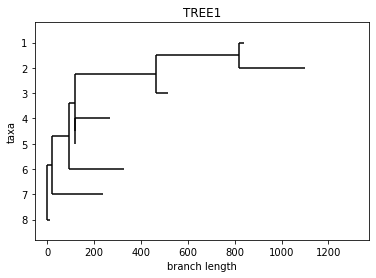

Branch: 0.PE
Rename: GCA_002412235.1_Y.pestis_A_1249_genomic_44 GCA_002412235.1_Y.pestis_A-1249_genomic_44
Rename: GCA_003122795.1_Y.pestis_I_2422_genomic_40 GCA_003122795.1_Y.pestis_I-2422_genomic_40


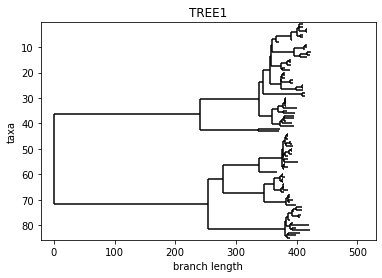

Branch: 0.ANT
Rename: GCA_002412225.1_Y.pestis_A_1486_genomic_53 GCA_002412225.1_Y.pestis_A-1486_genomic_53
Rename: GCA_002412255.1_Y.pestis_A_1836_genomic_36 GCA_002412255.1_Y.pestis_A-1836_genomic_36
Rename: GCA_002412245.1_Y.pestis_A_1691_genomic_48 GCA_002412245.1_Y.pestis_A-1691_genomic_48


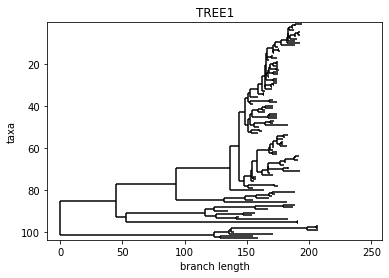

Branch: 0.ANT4


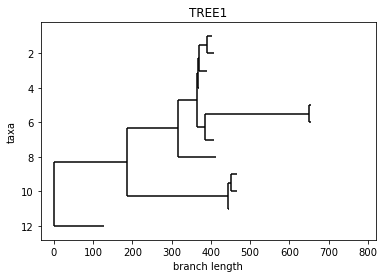

Branch: 3.ANT


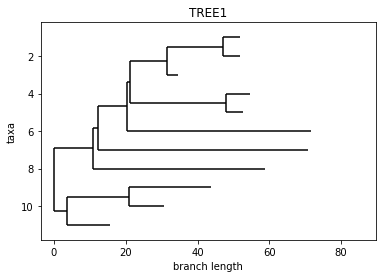

Branch: 4.ANT


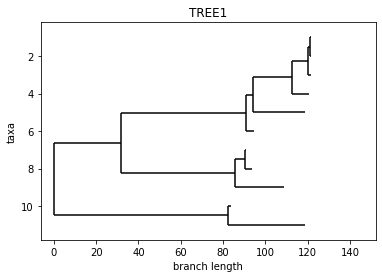

Branch: 2.ANT


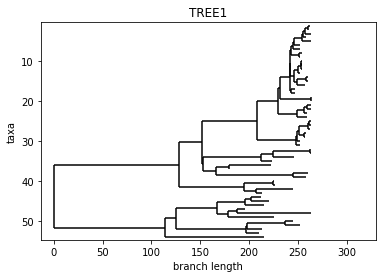

Branch: 1.PRE


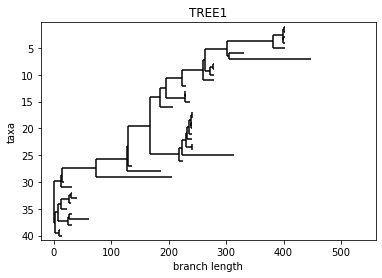

Branch: 1.ANT


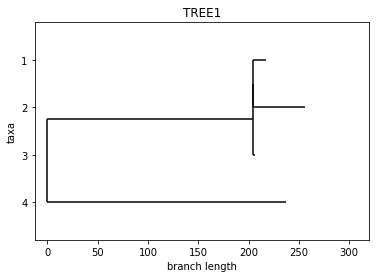

Branch: 1.IN


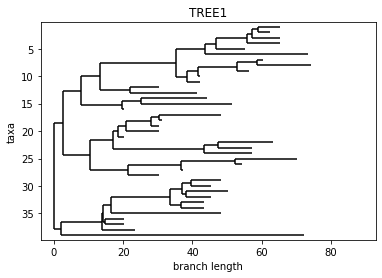

Branch: 1.ORI
Rename: GCA_000986995.1_YPES001_SEQ_2_ASM_1_genomic_22 GCA_000986995.1_YPES001-SEQ-2-ASM-1_genomic_22
Rename: GCA_000324805.2_EV76_CN_genomic_90 GCA_000324805.2_EV76-CN_genomic_90


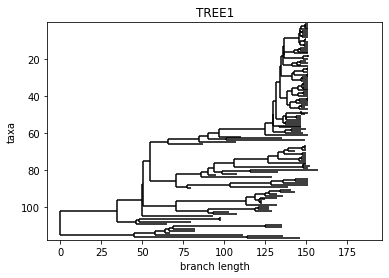

In [11]:
# Construct a dictionary to hold the trees
tree_dict = {}

for branch in ["prune"] + BRANCH_LIST_REVERSE:
    for filename in os.listdir(tree_dir):
        if not filename.endswith(".tree") and not filename.endswith(".tre"): continue
        # For clock model 
        if "clade/phylogeography" not in tree_dir and "UCLN" not in filename: continue
            
        filepath = os.path.join(tree_dir, filename)
        
        # Check file matches branch
        filename_strip = filename.split("_")[0].replace("SC","").replace("UCLN","")
        if filename_strip == branch:
        
            print("Branch:", branch)
            tree_dict[branch] = {}  
            
            # Add tree files to dict
            tree_dict[branch]["tree_file_raw"] = filepath 
            tree_dict[branch]["tree_file_edit"] = os.path.join(tree_dir, branch + ".nex")
            tree_dict[branch]["sample_rename"] = {}
            
            # Read in raw tree to deal with dashes
            with open(tree_dict[branch]["tree_file_raw"],  "r") as infile:                    
                with open(tree_dict[branch]["tree_file_edit"], "w") as outfile:           
                    raw_tree = infile.read()
                    # Remove quotations if they exist
                    raw_tree = raw_tree.replace("'","")
                    
                    # Split into lines to iterate over
                    raw_tree_lines = raw_tree.split("\n")
                    
                    # By default don't parse a line for dashes
                    taxa_line = False
                    
                    for line in raw_tree_lines: 
                                
                        if "TREE" not in line and "-" in line:
                            
                            if len(line.split(" ")) == 1:
                                name_dashes = line.strip()
                                name_no_dashes = name_dashes.replace("-","_")
                                tree_dict[branch]["sample_rename"][name_no_dashes] = name_dashes
                            line = line.replace("-","_")
                                
                        outfile.write(line + "\n")
            
            # Read in edited tree
            trees = Phylo.parse(tree_dict[branch]["tree_file_edit"], "nexus")
            # There should be only 1 tree
            for t in trees:
                tree_dict[branch]["tree"] = t
                tree_dict[branch]["tree"].ladderize(reverse=True)
                break

            # Rename sample names back to with dashes
            for c in tree_dict[branch]["tree"].find_clades():
                if c.name in tree_dict[branch]["sample_rename"]:
                    orig_name = c.name
                    c.name = tree_dict[branch]["sample_rename"][c.name]
                    print("Rename:", orig_name, c.name)
                    
                # Strip the date suffix
                #if c.name:
                #    c.name = "_".join(c.name.split("_")[0:-1])           
                    
            # Rename internal nodes
            node_i = 0
            for c in tree_dict[branch]["tree"].find_clades():
                if not c.name:
                    c.name = "NODE{}".format(node_i)
                    node_i += 1
    
    if branch in tree_dict:
        Phylo.draw(tree_dict[branch]["tree"], label_func = lambda x: '')
            

## Log Files

In [12]:
# Construct a dictionary to hold the logs
log_dict = {}

for branch in ["prune"] + BRANCH_LIST_REVERSE:
    for filename in os.listdir(log_dir):
        if not filename.endswith(".log"): continue  
        # For clock model 
        if "clade/phylogeography" not in log_dir and "UCLN" not in filename: continue
            
        filepath = os.path.join(log_dir, filename)
        
        # Check file matches branch
        filename_strip = filename.split("_")[0].replace("SC","").replace("UCLN","")
        if filename_strip == branch:
        
            print("Branch:", branch)

            log_dict[branch] = {}  
            
            # Add log files to dict
            log_dict[branch]["log_file_raw"] = filepath 
            
            with open(filepath, "r") as infile:
                read_lines = infile.read().split("\n")
                            
            clean_lines = []
            header_found = False
            
            # Strip comments                
            for line in read_lines:
                if not line.startswith("#"):
                    clean_line = line.split("\t")
                    if not header_found:
                        header = clean_line
                        header_found = True
                    elif clean_line != [""]:
                        clean_lines.append(clean_line)
            
            # Store states and parameters as dict
            param_dict = {}
            for i in range(0,len(header)):
                param = header[i]
                values = [float(line[i]) for line in clean_lines]
                param_dict[param] = values
            
            # Construct data frame
            df = pd.DataFrame(param_dict)
            
            # Discard burnin
            burnin_lines = round(len(clean_lines) * BURNIN)
            df = df.iloc[burnin_lines:]
            
            # Add df to dict
            log_dict[branch]["log_df"] = df

Branch: prune
Branch: 0.PRE
Branch: 0.PE
Branch: 0.ANT
Branch: 0.ANT4
Branch: 3.ANT
Branch: 4.ANT
Branch: 2.ANT
Branch: 2.MED
Branch: 1.PRE
Branch: 1.ANT
Branch: 1.IN
Branch: 1.ORI


## Summary Data Frame

In [123]:
mega_df = pd.DataFrame(columns=["branch", "meanRate", "coefficientOfVariation", "age(root)", "log_meanRate", "stdevRate"])

branch_list = ["prune"] + BRANCH_LIST_REVERSE
branch_list.reverse()

for branch in branch_list:
    df = log_dict[branch]["log_df"]
    branches = [branch] * len(df)
    
    mean_rate = list(df["meanRate"])
    mean_rate_log = [np.log(rate) for rate in mean_rate]
    coefficient_of_variation = list(df["coefficientOfVariation"])
    
    stdev_rate = []
    stdev_rate_log = []
    for rate, coeff in zip(mean_rate, coefficient_of_variation):
        r = coeff * rate
        stdev_rate.append(r)
        if r == 0:
            stdev_rate_log.append(np.nan)
            continue
            
        r_log = np.log(r)        
        stdev_rate_log.append(r_log)
        
    age_root = list(df["age(root)"])
    
    mrsd = 2019
    if branch in mrsd_dict:
        mrsd = mrsd_dict[branch]
    age_root_calendar = [mrsd - age for age in age_root]
    
    data = {
        "branch": branches, 
        "meanRate": mean_rate, 
        "coefficientOfVariation": coefficient_of_variation,
        "age(root)" : age_root_calendar,
        "log_meanRate" : mean_rate_log,
        "stdevRate": stdev_rate,
        "log_stdevRate": stdev_rate_log,
    }
    data_df = pd.DataFrame(data)
    mega_df = mega_df.append(data_df)

display(mega_df)

,branch,meanRate,coefficientOfVariation,age(root),log_meanRate,stdevRate,log_stdevRate
0,1.ORI,1.290917e-07,2.270683,1870.199785,-15.862743,2.931263e-07,-15.042662
1,1.ORI,1.314774e-07,1.448497,1866.083827,-15.844431,1.904447e-07,-15.473904
2,1.ORI,1.536231e-07,1.489931,1892.098874,-15.688764,2.288878e-07,-15.290034
3,1.ORI,1.463154e-07,1.581295,1880.957022,-15.737501,2.313678e-07,-15.279257
4,1.ORI,1.234782e-07,1.426556,1870.652997,-15.907201,1.761486e-07,-15.551938
...,...,...,...,...,...,...,...
8996,prune,1.234131e-08,1.849490,-6235.697641,-18.210314,2.282513e-08,-17.595404
8997,prune,1.274758e-08,1.831241,-6190.730108,-18.177924,2.334389e-08,-17.572931
8998,prune,1.263891e-08,1.857745,-6057.513385,-18.186486,2.347987e-08,-17.567122
8999,prune,1.265684e-08,1.820325,-6122.519517,-18.185068,2.303957e-08,-17.586053


In [124]:
out_path = os.path.join(log_dir, "meanRate_coefficientOfVariation_ageRoot.tsv")
print(out_path)

with open(out_path, "w") as outfile:
    params = ["meanRate", "coefficientOfVariation", "age(root)"]   
    header = ["branch"]
    for param in params:
        header.append(param)
        header.append(param + "_ci")
    line = "{}\t{}\t{}\t{}\t{}\t{}\t{}".format(*header)
    outfile.write(line + "\n")
    for branch in log_dict:
        df = mega_df[mega_df["branch"] == branch]
        param_dict = {h:0 for h in header}
        param_dict["branch"] = branch
        params = ["meanRate", "coefficientOfVariation", "age(root)"]
        
        for param in params:
            kde = sma.nonparametric.KDEUnivariate(
                df[param]
            )
            kde.fit()
            peak_i = np.argmax(kde.density)
            peak = kde.support[peak_i]
            ci = np.array(
                np.percentile(
                    np.array(df[param]),
                    (100 - 95, 95),
                    axis=0,
                )
            )
            if "age" in param:
                ci_pretty = str([round(n) for n in ci]).strip("[]").replace(" ","")
            elif "coeff" in param:
                ci_pretty = str([round(n, 2) for n in ci]).strip("[]").replace(" ","")
            else:
                ci_pretty = str([n for n in ci]).strip("[]").replace(" ","")

            param_dict[param] = peak
            param_dict[param + "_ci"] = ci_pretty
        
        data = param_dict.values() 
        line = "{}\t{}\t{}\t{}\t{}\t{}\t{}".format(*data)
        outfile.write(line + "\n")
        
        log_dict[branch]["param_dict"] = param_dict

/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main//beast/all/chromosome/clade/log/meanRate_coefficientOfVariation_ageRoot.tsv


## Plot Mean Rate

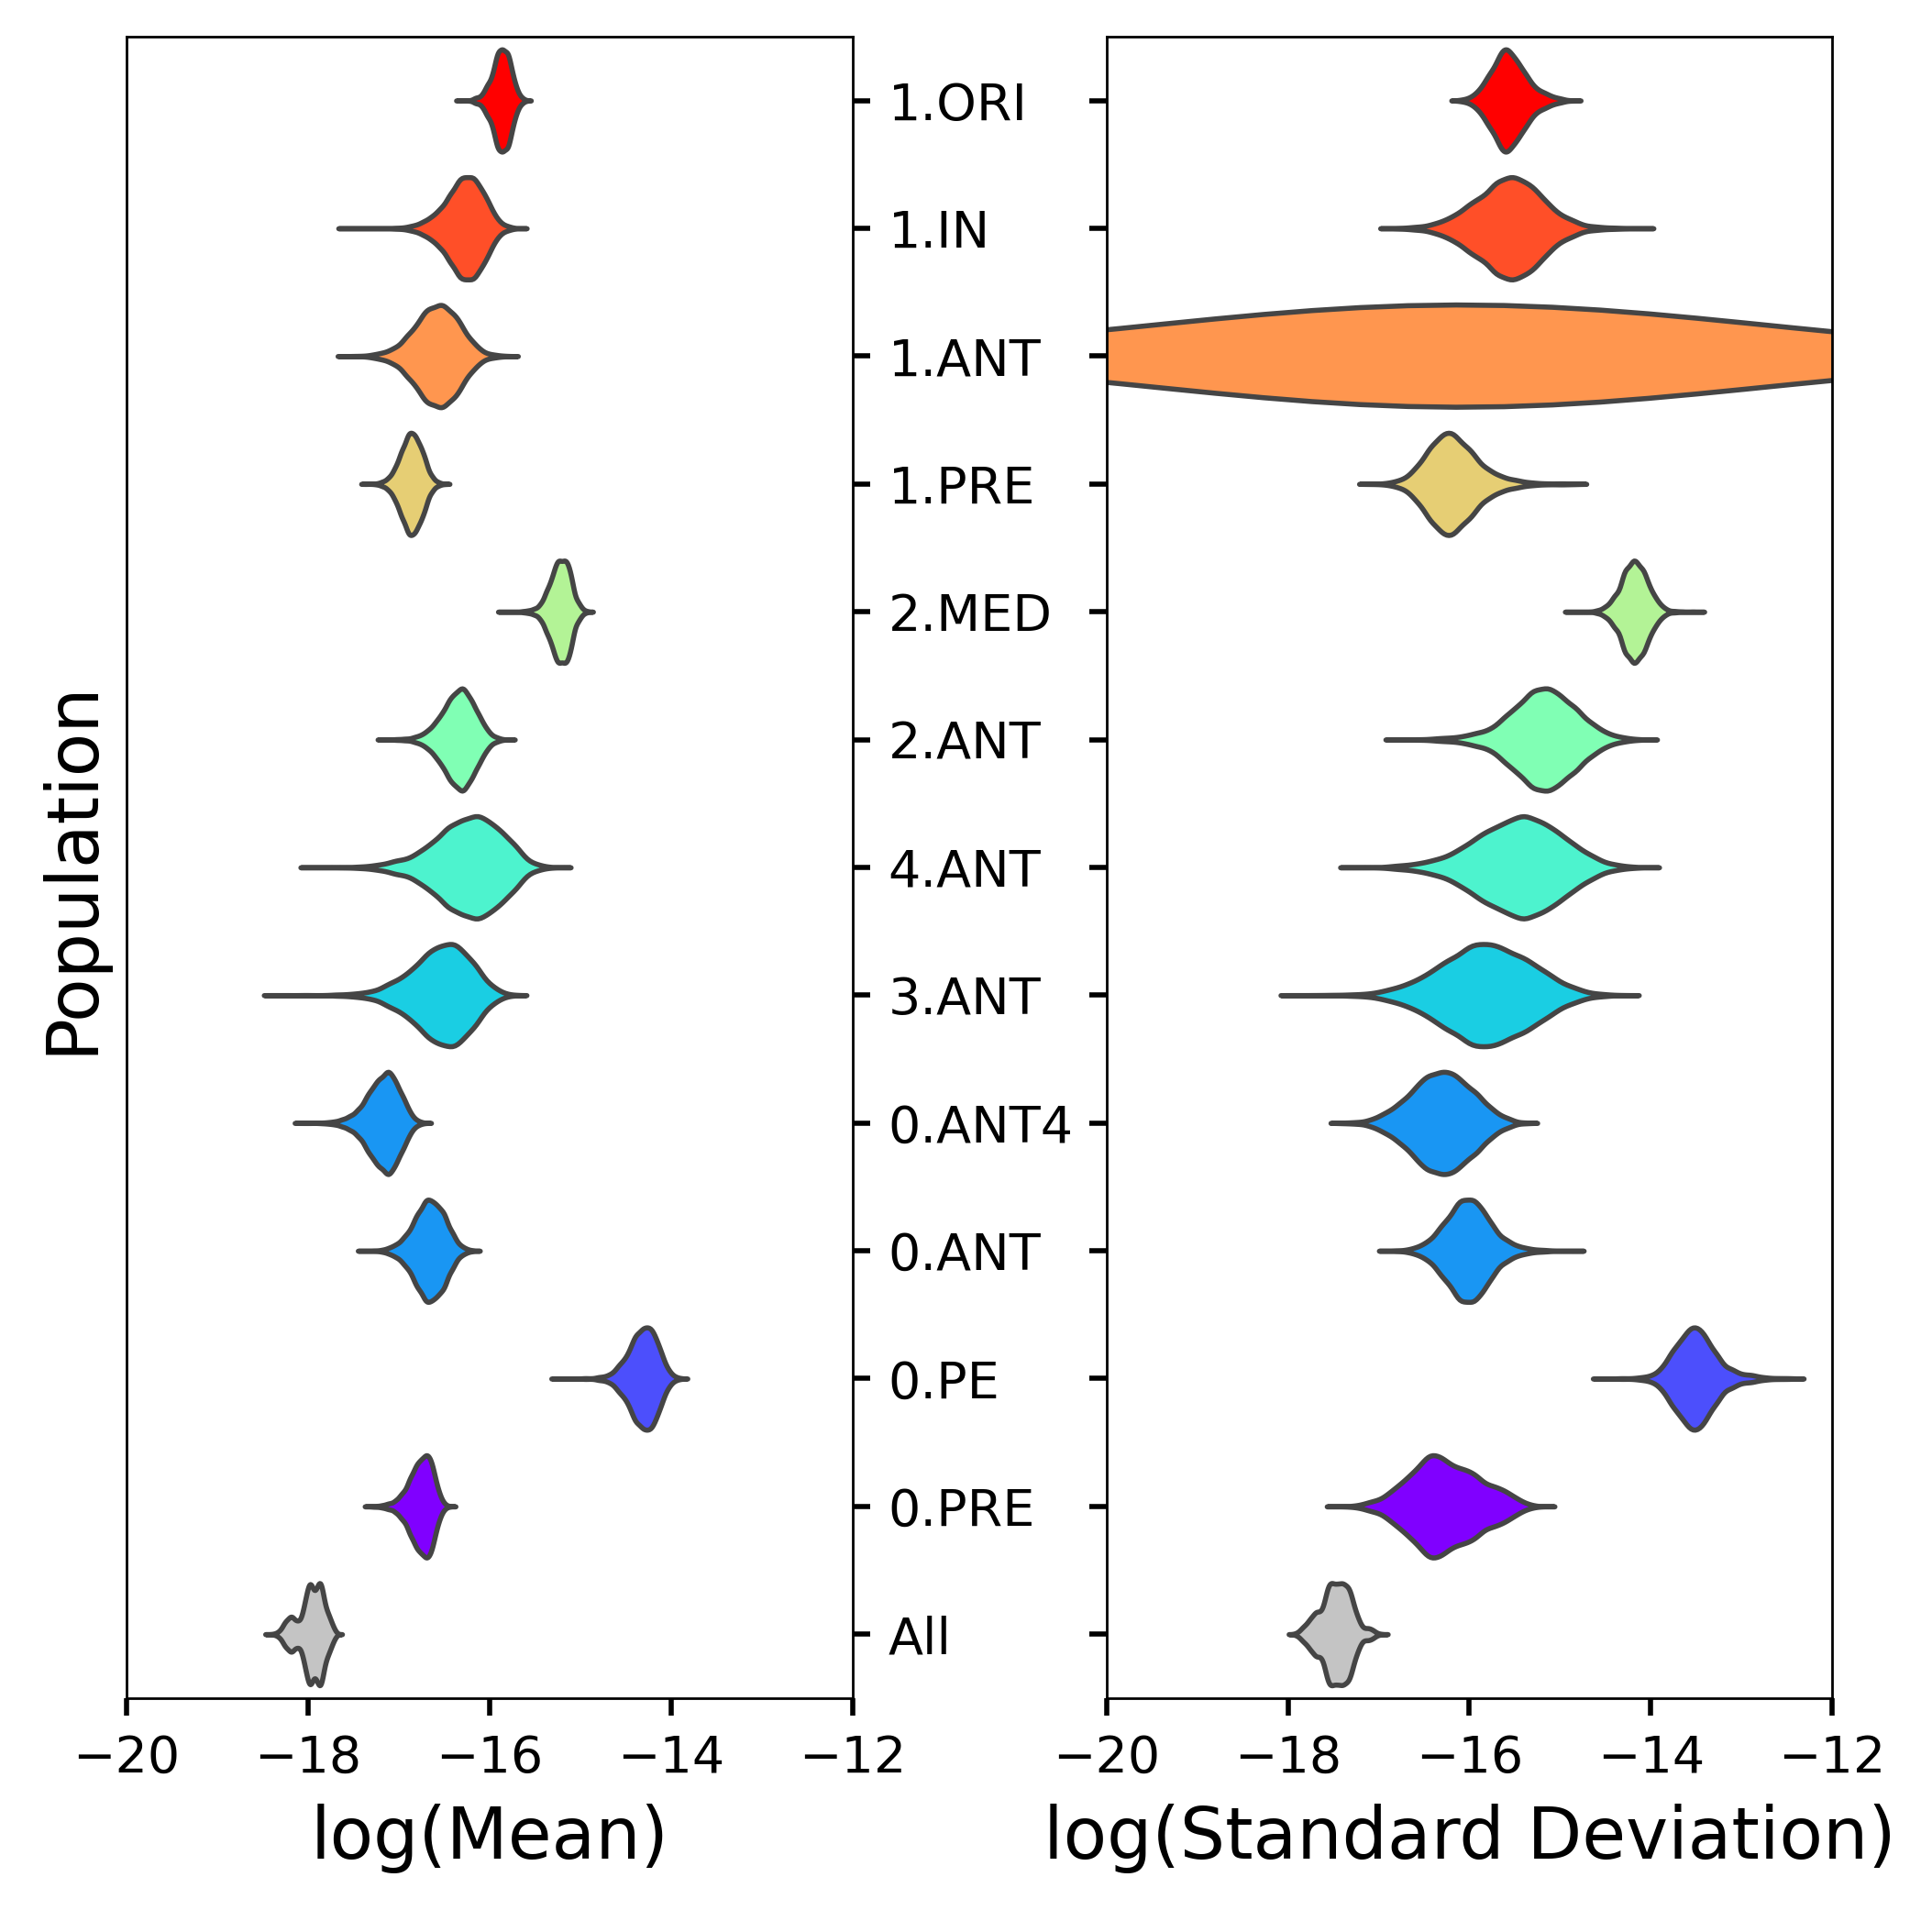

In [144]:
FONTSIZE=12
plt.rc('font', size=FONTSIZE)
DPI=400
LINEWIDTH=1
FIGSIZE=[6,6]

## All
fig, axes = plt.subplots(1, 2, figsize=FIGSIZE, dpi=DPI, sharey=True)
fig.subplots_adjust(wspace=0.35)

branch_list = ["prune"] + BRANCH_LIST_REVERSE
branch_list.reverse()

# -------------------------------
# Mean Substitution Rate
ax = axes[0]

# Regular
#sns.violinplot(ax=ax, data=mega_df, y="branch", x="meanRate", inner=None, scale="width", order=branch_list)
#ax.set_xlim(min(mega_df["meanRate"]) - 1e-7, max(mega_df["meanRate"]) + 2e-7)
#ax.set_xlabel("Mean Substitution Rate", fontsize=FONTSIZE + 2)

# Log
sns.violinplot(ax=ax, data=mega_df, y="branch", x="log_meanRate", inner=None, scale="width", order=branch_list)
#ax.set_xlim(min(mega_df["log_meanRate"]) - 0.5, max(mega_df["log_meanRate"]) + 2)
ax.set_xlim(-20, -12)  
ax.set_xlabel("log(Mean)", fontsize=FONTSIZE + 2)

ax.set_ylabel("Population", fontsize=FONTSIZE + 2)

# -------------------------------
# Standard Deviation
ax = axes[1]
#df = mega_df[(mega_df["log_stdevRate"] != np.nan) & (mega_df["branch"] != "1.ANT")]
df = mega_df[(mega_df["log_stdevRate"] != np.nan)]
# Regular
#sns.violinplot(ax=ax, data=df, y="branch", x="stdevRate", inner=None, scale="width", order=branch_list)
#ax.set_xlim(-0.5, max(mega_df["coefficientOfVariation"]) + 2)

# Log
sns.violinplot(ax=ax, data=df, y="branch", x="log_stdevRate", inner=None, scale="width", order=branch_list)
ax.set_xlim(-20, -12)  
ax.set_xlabel("log(Standard Deviation)", fontsize=FONTSIZE + 2)
# -------------------------------
# Style
for ax in axes:
    
    if ax == axes[0]:
        ax.yaxis.tick_right()
    # Linewidths
    ax.xaxis.set_tick_params(width=LINEWIDTH)
    ax.yaxis.set_tick_params(width=LINEWIDTH)
    
    # Fontsizes
    ax.tick_params(axis='x', labelsize=FONTSIZE - 2)
    ax.tick_params(axis='y', labelsize=FONTSIZE - 2)
    
    if ax != axes[0] and ax != axes[-1]:
        ax.set_yticks([])
        ax.set_ylabel("")
    else:
        labels = copy.deepcopy(branch_list)
        labels[-1] = "All"
        ax.set_yticklabels(labels=labels)
        
        if ax == axes[-1]:
            #ax.yaxis.tick_right()
            ax.set_ylabel("")
            
    # Iterate through items in axis
    for spine in ax.spines:
        ax.spines[spine].set_linewidth(0.5)
        
    for i in range(0, len(ax.collections)):
        collection = ax.collections[i]

        branch = branch_list[i]
        color = "#c4c4c4"
        if branch in colors_dict["branch_major"]:
            color = colors_dict["branch_major"][branch]

        collection.set_facecolor(color)
        collection.set_linewidth(LINEWIDTH)
        
# Save
out_path = os.path.join(log_dir, "meanRate_stdev")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")   

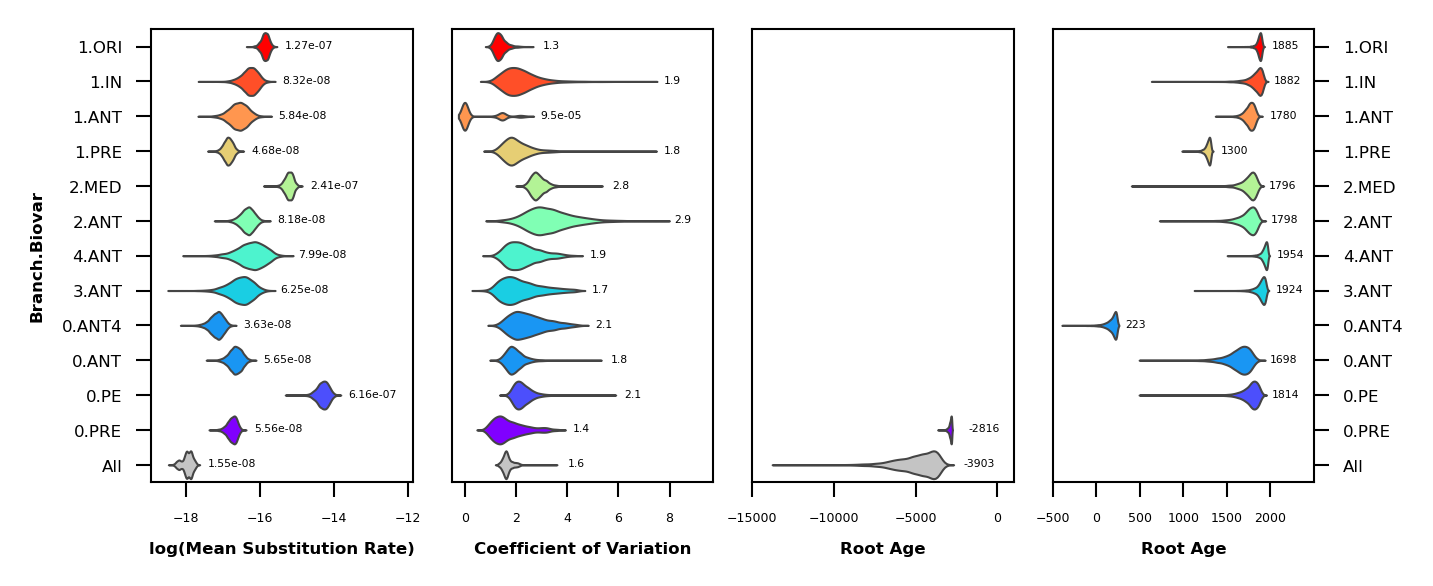

In [18]:
"""FONTSIZE=4
LINEWIDTH=0.5
plt.rc('font', size=FONTSIZE)
plt.rc('lines', linewidth=LINEWIDTH)

fig, axes = plt.subplots(1, 4, figsize=(5,2), dpi=300, gridspec_kw={'width_ratios': [1,1,1,1]})
fig.subplots_adjust(wspace=0.15)

branch_list = ["prune"] + BRANCH_LIST_REVERSE
branch_list.reverse()


# -------------------------------
# Mean Substitution Rate
ax = axes[0]

sns.violinplot(ax=ax, data=mega_df, y="branch", x="log_meanRate", inner=None, scale="width", order=branch_list)
ax.set_xlabel("log(Mean Substitution Rate)", fontsize=FONTSIZE * 1, fontweight="bold")
ax.set_ylabel("Branch.Biovar", fontsize=FONTSIZE * 1, fontweight="bold")
ax.set_xlim(min(mega_df["log_meanRate"]) - 0.5, max(mega_df["log_meanRate"]) + 2)

# Text
for i in range(len(ax.collections)): 
    branch = branch_list[i]
    branch_df = mega_df[mega_df["branch"] == branch]
    max_log_rate = max(branch_df["log_meanRate"])
    peak = log_dict[branch]["param_dict"]["meanRate"]
    
    xbuff = 0.25
    ybuff = 0.05
    ax.annotate(
        ("{:.2e}".format(peak)),
        xy=(max_log_rate + xbuff, i + ybuff),
        xycoords="data",
        fontsize=FONTSIZE * 0.65,
    )
    
# -------------------------------
# Coefficient of Variation
ax = axes[1]

sns.violinplot(ax=ax, data=mega_df, y="branch", x="coefficientOfVariation", inner=None, scale="width", order=branch_list)
ax.set_xlabel("Coefficient of Variation", fontsize=FONTSIZE * 1, fontweight="bold")    
ax.set_xlim(-0.5, max(mega_df["coefficientOfVariation"]) + 2)

# Text
for i in range(len(ax.collections)): 
    branch = branch_list[i]
    branch_df = mega_df[mega_df["branch"] == branch]
    max_coeff = max(branch_df["coefficientOfVariation"])
    peak = log_dict[branch]["param_dict"]["coefficientOfVariation"]
    
    xbuff = 0.5
    ybuff = 0.05
    ax.annotate(
        ("{:.2}".format(peak)),
        xy=(max_coeff + xbuff, i + ybuff),
        xycoords="data",
        fontsize=FONTSIZE * 0.65,
    )

# -------------------------------
# Age Root
ax = axes[2]

df = mega_df[(mega_df["branch"] == 'prune') | (mega_df["branch"] == '0.PRE')]
sns.violinplot(ax=ax, data=df, y="branch", x="age(root)", inner=None, scale="width", order=branch_list)
ax.set_xlabel("Root Age", fontsize=FONTSIZE * 1, fontweight="bold")        
ax.set_xlim(-15001,1001)

# Text
num_collections = len(ax.collections)
num_labels = len(branch_list + ["prune"])
i_start = num_labels - num_collections - 1
for i in range(len(ax.collections)):
    branch = branch_list[0-len(ax.collections):][i]
    branch_df = mega_df[mega_df["branch"] == branch]
    max_age = max(branch_df["age(root)"])
    peak = log_dict[branch]["param_dict"]["age(root)"]
    
    xbuff = 1000
    ybuff = 0.05
    ax.annotate(
        ("{}".format(round(peak))),
        xy=(max_age + xbuff, i + i_start + ybuff),
        xycoords="data",
        fontsize=FONTSIZE * 0.65,
    )

# -------------------------------
# Age Clade
ax = axes[3]

df = mega_df[(mega_df["branch"] != 'prune') & (mega_df["branch"] != '0.PRE')]
sns.violinplot(ax=ax, data=df, y="branch", x="age(root)", inner=None, scale="width", order=branch_list)
ax.set_xlabel("Root Age", fontsize=FONTSIZE * 1, fontweight="bold")        
ax.set_xticks(range(-500,2500,500))
ax.set_xlim(-500, 2500)

# Text
for i in range(len(ax.collections)): 
    branch = branch_list[i]
    branch_df = mega_df[mega_df["branch"] == branch]
    max_age = max(branch_df["age(root)"])
    peak = log_dict[branch]["param_dict"]["age(root)"]
    
    xbuff = 100
    ybuff = 0.05
    ax.annotate(
        ("{}".format(round(peak))),
        xy=(max_age + xbuff, i + ybuff),
        xycoords="data",
        fontsize=FONTSIZE * 0.65,
    )

# -------------------------------
# Style
for ax in axes:
    # Linewidths
    ax.xaxis.set_tick_params(width=LINEWIDTH)
    ax.yaxis.set_tick_params(width=LINEWIDTH)
    
    # Fontsizes
    ax.tick_params(axis='x', labelsize=FONTSIZE * 0.75)
    ax.tick_params(axis='y', labelsize=FONTSIZE)
    
    if ax != axes[0] and ax != axes[-1]:
        ax.set_yticks([])
        ax.set_ylabel("")
    else:
        labels = copy.deepcopy(branch_list)
        labels[-1] = "All"
        ax.set_yticklabels(labels=labels)
        if ax == axes[-1]:
            ax.yaxis.tick_right()
            ax.set_ylabel("")
            
    # Iterate through items in axis
    for spine in ax.spines:
        ax.spines[spine].set_linewidth(0.5)
        
    for i in range(0, len(ax.collections)):
        collection = ax.collections[i]
        branch = branch_list[i]
        # Samples from base
        if ax == axes[2]:
            branch = branch_list[0-len(ax.collections):][i]
        color = "#c4c4c4"
        if branch in colors_dict["branch_major"]:
            color = colors_dict["branch_major"][branch]

        collection.set_facecolor(color)
        collection.set_linewidth(LINEWIDTH) 

    


# Save
#out_path = os.path.join(log_dir, "meanRate_coefficientOfVariation_ageRoot")
plt.savefig(out_path + ".png", bbox_inches="tight", facecolor="white")
plt.savefig(out_path + ".svg", bbox_inches="tight")
"""

## All tMRCA

In [ ]:
SCALE=4
FIGSIZE=[8*SCALE,3*SCALE]
FONTSIZE=4*SCALE
LINEWIDTH=0.5*SCALE
FRAME=0.5*SCALE
DPI=300
plt.rc('font', size=FONTSIZE)
plt.rc('lines', linewidth=LINEWIDTH)
fig, axes = plt.subplots(1, 1, figsize=FIGSIZE, dpi=DPI)

branch_list = ["prune"] + BRANCH_LIST_REVERSE
branch_list.reverse()

# -------------------------------
# Age Clade
ax = axes

sns.violinplot(ax=ax, data=mega_df, y="branch", x="age(root)", inner=None, scale="width", order=branch_list)
ax.set_xlabel("tMRCA Calendar Date", fontsize=FONTSIZE * 1, fontweight="bold")        
ax.set_ylabel("Branch.Biovar", fontsize=FONTSIZE * 1, fontweight="bold")  
"""# Text
for i in range(len(ax.collections)): 
    branch = branch_list[i]
    branch_df = mega_df[mega_df["branch"] == branch]
    max_age = max(branch_df["age(root)"])
    peak = log_dict[branch]["param_dict"]["age(root)"]
    
    xbuff = 200
    ybuff = 0.05
    ax.annotate(
        ("{}".format(round(peak))),
        xy=(max_age + xbuff, i + ybuff),
        xycoords="data",
        fontsize=FONTSIZE * 0.65,
    )"""
    
# -------------------------------
# Style

# Linewidths
ax.xaxis.set_tick_params(width=LINEWIDTH)
ax.yaxis.set_tick_params(width=LINEWIDTH)

# Fontsizes
ax.tick_params(axis='x', labelsize=FONTSIZE * 0.75)
ax.tick_params(axis='y', labelsize=FONTSIZE)

labels = copy.deepcopy(branch_list)
labels[-1] = "All"
ax.set_yticklabels(labels=labels)

# Iterate through items in axis
for spine in ax.spines:
    ax.spines[spine].set_linewidth(FRAME)

for i in range(0, len(ax.collections)):
    collection = ax.collections[i]
    branch = branch_list[i]
    color = "#c4c4c4"
    if branch in colors_dict["branch_major"]:
        color = colors_dict["branch_major"][branch]

    collection.set_facecolor(color)
    collection.set_linewidth(LINEWIDTH) 
    
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_ylim(ylim[0] + 0.5, ylim[1])
ax.xaxis.set_major_locator(ticker.MultipleLocator(1000))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(500))

# Save
out_path = os.path.join(log_dir, "tMRCA")
plt.savefig(out_path + ".png", bbox_inches="tight", facecolor="white")
plt.savefig(out_path + ".svg", bbox_inches="tight")

## MRCA

In [ ]:
nrow=3
ncol=4

fig, axes = plt.subplots(nrow,ncol,figsize=(8,6), dpi=300)
fig.subplots_adjust(
    wspace=0.40, 
    hspace=0.85,
)

i_row = 0
i_col = 0

for branch in BRANCH_LIST_REVERSE:
    # ----------------------------------------
    # Setup axis
    ax = axes[i_row][i_col]

    df = mega_df[mega_df["branch"] == branch]
    color = colors_dict["branch_major"][branch]
    
    ax.set_title(branch)
    ax.set_xlabel("Calendar Date")
    ax.set_ylabel("Density")
    
    if len(df) < 3:
        # Update axis
        if i_col == ncol - 1:
            i_col = 0
            i_row += 1
        else:
            i_col += 1        
        continue  

    for spine in ax.spines:
        ax.spines[spine].set_linewidth(0.5)  
    
    age_kde = sma.nonparametric.KDEUnivariate(
        df["age(root)"]
    )
    age_kde.fit()
    peak_age_i = np.argmax(age_kde.density)
    peak_age = round(age_kde.support[peak_age_i])
    mean_age = round(sum(df["age(root)"]) / len(df["age(root)"]))
    ci_age = np.array(
        np.percentile(
            np.array(df["age(root)"]),
            (100 - 95, 95),
            axis=0,
        )
    )
    ci_age_pretty = str([round(n) for n in ci_age]).strip("[]")
    sns.kdeplot(ax=ax, data=df, x="age(root)", fill=True, color=color)
    ax.axvline(x=peak_age, color="black", lw=0.5, zorder=0)
    ax.axvline(x=ci_age[0], color="black", ls="--", lw=0.5)
    ax.axvline(x=ci_age[1], color="black", ls="--", lw=0.5)
    # Annotate stats
    ax.annotate(
        ("       Peak: {}".format(peak_age)
        + "\n95% HPD: {}".format(ci_age_pretty)),
        xy=(0.15, -0.5),
        xycoords="axes fraction",
        size=5,
        ha="left",
        va="center",
        bbox=dict(fc="w", lw=0.5),
    )
        
    # Update axis
    if i_col == ncol - 1:
        i_col = 0
        i_row += 1
    else:
        i_col += 1 

out_path = os.path.join(log_dir, "age_root_clades")
plt.savefig(out_path + ".png", bbox_inches="tight", facecolor="white")
plt.savefig(out_path + ".svg", bbox_inches="tight")

## Add Tree Data to Dataframe

### Get comments from the first root that is not root

In [ ]:
TREE_PARAMETERS = None

for branch in tree_dict:
    
    print(branch)
    
    tree = tree_dict[branch]["tree"]
    df = copy.deepcopy(metadata_df[metadata_df["branch_minor"].isin(BRANCH_LIST[branch])])
    
    # Check if a sample was missed :(
    df_samples = df.index
    tree_samples = [c.name for c in tree.find_clades()]
    
    for sample in df_samples:
        if sample not in tree_samples:
            df.drop(sample, inplace=True)
            print("Dropping {} from the dataframe.".format(sample))
    
    root_comment_dict = parse_comment(tree.root.comment)
    
    for c in tree.find_clades():
        if c.is_terminal():
            continue
            
        if c != tree.root:
            comment_dict = parse_comment(c.comment)
            for parameter,value in comment_dict.items():
                # Intialize parameter values
                if "range" in parameter or "95%" in parameter:
                    df[parameter] = [[NO_DATA_CHAR,NO_DATA_CHAR]] * len(df)
                    if parameter not in root_comment_dict:
                        root_comment_dict[parameter] = '{0,0}'
                else:
                    df[parameter] = [NO_DATA_CHAR] * len(df)
                    if parameter not in root_comment_dict:
                        root_comment_dict[parameter] = '0'
                    
            break

    # Update the roots comment to include missing values
    new_comment = "[&"
    new_comment_list = []
    for parameter,value in root_comment_dict.items():
        param_str = "{}={}".format(parameter, value)
        new_comment_list.append(param_str)
    new_comment += ",".join(new_comment_list) + "]"
    tree.root.comment = new_comment
    #print(root_comment_dict)
    #print(new_comment_list)
    
    if not TREE_PARAMETERS:
        TREE_PARAMETERS = [p for p in root_comment_dict]
    
    tree_dict[branch]["df"] = df 
    #display(df)

### Parse Tree Comments

In [ ]:
parameters = [
    "branch_length",
    "branch_length_sub",
    "node_type",    
    "branch_support",
    "branch_support_conf_category",
    "branch_support_conf_char",
    "country_date_strain",
    "province_date_strain",
    "rate",
    "rate_hpd",
    "rate_sub",
    "rate_sub_year",
    "state",
    "state_prob",
    "state_conf_category",
    "state_rate",
    "state_rate_hpd",
    "state_continent",
    "state_lat",
    "state_lon",
    "height",
    "height_hpd",
    "timetree_num_date",
    "timetree_num_date_confidence",
]

for branch in tree_dict:
    print(branch)
    
    tree = tree_dict[branch]["tree"]
    df = tree_dict[branch]["df"]
    
    # Add to dataframe
    for param in parameters:
        df[param] = [NO_DATA_CHAR] * len(df)
        
    for c in tree.find_clades():
        # Defaults
        node_type = "internal"
        branch_support = 0
        branch_support_conf_category = "LOW"
        branch_support_conf_char = ""
        branch_length = 0
        branch_length_sub = 0
        country_date_strain = NO_DATA_CHAR
        province_date_strain = NO_DATA_CHAR
        rate_hpd = [0,0]
        rate = 0
        rate_sub_year = 0
        state = NO_DATA_CHAR
        state_conf_category = "LOW"
        state_prob = 0
        state_rate = 0
        state_continent = NO_DATA_CHAR
        state_lat = NO_DATA_CHAR
        state_lon = NO_DATA_CHAR
        
        
        timetree_num_date = 0
        timetree_num_date_confidence = [0,0]
        height = 0
        height_hpd = [0,0]
        
        
        comment_dict = parse_comment(c.comment)
        #print(comment_dict.keys())

        # Branch Length
        if c.branch_length:
            branch_length = c.branch_length

        # Branch support
        if "posterior" in comment_dict:
            branch_support = float(round(float(comment_dict["posterior"]) * 100))
            if branch_support >= 95:
                branch_support_conf_category = "HIGH"
                branch_support_conf_char = "*"

        # Rates
        if "default.rate" in comment_dict:
            rate = float(comment_dict["default.rate"])
            rate_sub = rate

            if c.branch_length:
                rate_sub_year = rate * SEQ_LEN
                branch_length_sub = rate_sub_year * c.branch_length

        if "default.rate_95%_HPD" in comment_dict:
            rate_hpd_split = comment_dict["default.rate_95%_HPD"].strip("{}").split(",")
            rate_hpd = [float(r) for r in rate_hpd_split]
            
        if "state.rate" in comment_dict:
            state_rate = float(comment_dict["state.rate"])   

        if "state.rate_95%_HPD" in comment_dict:
            state_rate_hpd_split = comment_dict["state.rate_95%_HPD"].strip("{}").split(",")
            state_rate_hpd = [float(r) for r in state_rate_hpd_split]            
    
        # States
        if "state" in comment_dict:
            state = comment_dict["state"]
            state_continent = continent_dict[state]
            state_latlon_dict = dict(latlon_country_df.loc[state])
            state_lat = float(state_latlon_dict["lat"])
            state_lon = float(state_latlon_dict["lon"])
            
            
        if "state.prob" in comment_dict:
            state_prob = float(round(float(comment_dict["state.prob"]) * 100))
            if state_prob >= 95:
                state_conf_category = "HIGH"


        # Dates
        
        if "height" in comment_dict:
            height = float(comment_dict["height"])

        if "height_95%_HPD" in comment_dict:
            height_hpd_split = comment_dict["height_95%_HPD"].strip("{}").split(",")
            height_hpd = [float(h) for h in height_hpd_split]
        
        height_hpd_reverse = copy.copy(height_hpd)
        height_hpd_reverse.reverse()
        timetree_num_date = float(round(mrsd_dict[branch] - height))
        timetree_num_date_confidence = [round(mrsd_dict[branch] - h) for h in height_hpd_reverse]  

        if c.is_terminal():
            node_type = "terminal"
            country = metadata_df["country"][c.name]
            province = metadata_df["province"][c.name]
            date = metadata_df["date"][c.name]
            strain = metadata_df["strain"][c.name]

            country_date_strain = "{} {} {}".format(country, date, strain)
            province_date_strain = "{} {} {}".format(province, date, strain)
            
        
        df.at[c.name, "branch_length"] = branch_length
        df.at[c.name, "branch_length_sub"] = branch_length_sub
        df.at[c.name, "node_type"] = node_type
        df.at[c.name, "branch_support"] = branch_support
        df.at[c.name, "branch_support_conf_category"] = branch_support_conf_category
        df.at[c.name, "branch_support_conf_char"] = branch_support_conf_char
        df.at[c.name, "country_date_strain"] = country_date_strain
        df.at[c.name, "province_date_strain"] = province_date_strain

        
        df.at[c.name, "rate"] = rate
        df.at[c.name, "rate_hpd"] = rate_hpd
        df.at[c.name, "rate_sub"] = rate_sub
        df.at[c.name, "rate_sub_year"] = rate_sub_year
        
        df.at[c.name, "state"] = state
        df.at[c.name, "state_prob"] = state_prob
        df.at[c.name, "state_conf_category"] = state_conf_category
        df.at[c.name, "state_continent"] = state_continent
        df.at[c.name, "state_lat"] = state_lat
        df.at[c.name, "state_lon"] = state_lon
        
        df.at[c.name, "state_rate"] = state_rate
        df.at[c.name, "state_rate_hpd"] = state_rate_hpd
        
        df.at[c.name, "height"] = height
        df.at[c.name, "height_hpd"] = height_hpd   
        
        df.at[c.name, "timetree_num_date"] = timetree_num_date
        df.at[c.name, "timetree_num_date_confidence"] = timetree_num_date_confidence        

    # Update internal nodes NA
    df.fillna(NO_DATA_CHAR, inplace=True)
    #display(df)

In [ ]:
## State Confidence Summary
print("{}\t{}\t{}\t{}".format("branch", "high", "internal", "% high" ))
for branch in tree_dict:
    
    tree = tree_dict[branch]["tree"]
    df = tree_dict[branch]["df"]
    internal_nodes = 0
    high_state_prob = 0
    
    for rec in df.iterrows():
        sample = rec[0]
        # Focus on internal branches
        if rec[1]["node_type"] == "terminal": continue
        state_prob = rec[1]["state_prob"]
        internal_nodes += 1
        if state_prob >= 95:
            high_state_prob += 1
        perc = round((high_state_prob / internal_nodes) * 100, 0)
    print("{}\t{}\t{}\t{}".format(branch, high_state_prob, internal_nodes, perc))

## Reduced Dataframe for Auspice

In [ ]:
# Options
print(tree_dict[branch]["df"].columns)

In [ ]:
for branch in tree_dict:
    print(branch)
    
    columns = [
        # Required
        "branch_length",
        "branch_length_sub",
        "node_type",
        # Time Tree
        "timetree_num_date",
        "timetree_num_date_confidence",
        # Geo
        #"country",
        "province",
        "state",
        "state_prob",
        "state_conf_category",
        "state_rate",
        "state_continent",
        "state_lat",
        "state_lon",
        #"continuous_geo",
        # Colors and Filters 
        "branch_major",
        "branch_minor",
        "branch_support",
        "branch_support_conf_category",  
        "branch_support_conf_char",  
        #"continent",
        "province_lat",
        "province_lon",
        #"country_lat",
        #"country_lon",
        # Text Description
        "biosample_accession",
        "strain",
        "country_date_strain",
        "province_date_strain",
        "host_human",
        # Tip Dates
        "date_mean",
        "date_err",
        "date_bp_mean",
        # Stats
        "root_rtt_dist",
        "clade_rtt_dist",
        "rate_sub",
        "rate_sub_year",
    ]
    
    auspice_df = copy.copy(tree_dict[branch]["df"][columns])

    # Edit df
    auspice_df["node_name"] = list(auspice_df.index)
    auspice_df["blank"] = [" "] * len(auspice_df)       
    
    # Rename
    auspice_df.rename(columns={"state": "country"}, inplace=True)
    auspice_df.rename(columns={"state_continent": "continent"}, inplace=True)
    auspice_df.rename(columns={"state_lat": "country_lat"}, inplace=True)
    auspice_df.rename(columns={"state_lon": "country_lon"}, inplace=True)
    
    # Make states grey if low confidence
    """for rec in auspice_df.iterrows():
        state_country = rec[1]["country"]
        state_continent = rec[1]["continent"]
        state_prob = rec[1]["state_prob"]
        if state_prob < 95:
            auspice_df.at[rec[0], "continent"] = NO_DATA_CHAR
            auspice_df.at[rec[0], "country"] = NO_DATA_CHAR"""
    
    display(auspice_df)
    tree_dict[branch]["auspice_df"] = auspice_df
    #break

---

# Export

## Time Tree

In [ ]:
for branch in tree_dict:
    out_timetree = copy.deepcopy(tree_dict[branch]["tree"])

    metadata_to_comment(out_timetree, tree_dict[branch]["df"])    
    out_timetree_nex_path = os.path.join(augur_dir, branch + ".timetree.nex")
    Phylo.write(out_timetree, out_timetree_nex_path, "nexus")

    for c in out_timetree.find_clades():
        c.comment = None

    out_timetree_nwk_path = os.path.join(augur_dir, branch + ".timetree.nwk")
    Phylo.write(out_timetree, out_timetree_nwk_path, "newick")

## Augur

In [ ]:
for branch in tree_dict:
    augur_dict = augur_export(
        tree_path=None, 
        aln_path=None,  
        tree=tree_dict[branch]["tree"], 
        tree_df=tree_dict[branch]["auspice_df"], 
        color_keyword_exclude=["geometry"],
        type_convert = {
            "branch_number" : (lambda x : str(x))
        },
    )
    
    tree_dict[branch]["augur_dict"] = augur_dict
    
    first_taxa = list(augur_dict["nodes"].keys())[0]
    print(augur_dict["nodes"][first_taxa])

    out_path_augur_json = os.path.join(augur_dir, branch + "_augur.json" )
    utils.write_json(data=tree_dict[branch]["augur_dict"], file_name=out_path_augur_json, indent=JSON_INDENT)
    tree_dict[branch]["augur_json_path"] = out_path_augur_json
    

## Auspice

In [ ]:
for branch in tree_dict:
    print(branch)
    # Store the color
    if branch == "0.ANT4":
        branch_major_color = colors_dict["branch_major"]["0.ANT"]
    else:
        branch_major_color = colors_dict["branch_major"][branch]

    auspice_dict = auspice_export(
        tree=tree_dict[branch]["tree"],
        augur_json_paths=tree_dict[branch]["augur_json_path"], 
        auspice_config_path=auspice_config_path, 
        auspice_colors_path=out_path_colors,
        auspice_latlons_path=out_path_latlon, 
        auspice_geo_res=["country","province"],
        )


    label_col = list(tree_dict[branch]["auspice_df"])
    #print(label_col)

    # Recursively add branch attrs
    branch_attributes(
        tree_dict=auspice_dict["tree"], 
        sub_dict=auspice_dict["tree"], 
        df=tree_dict[branch]["auspice_df"],
        label_col=label_col,
        )
    
    
    # Last manual changes
    auspice_dict_copy = copy.deepcopy(auspice_dict)
    for i in range(0, len(auspice_dict_copy["meta"]["colorings"])):
        coloring = auspice_dict_copy["meta"]["colorings"][i]
        for key in coloring:
            # Node type as internal or terminal
            if coloring[key] == "node_type":
                auspice_dict["meta"]["colorings"][i]['scale'] = [['internal', '#FFFFFF'], ['terminal', branch_major_color]]
                #print(auspice_dict["meta"]["colorings"][i])
            # Confidence category
            if "conf_category" in coloring[key]:
                auspice_dict["meta"]["colorings"][i]['scale'] = [['LOW', '#FFFFFF'], ['HIGH', branch_major_color]]
                #print(auspice_dict["meta"]["colorings"][i])
            # Host Human binary
            if "host_human" in coloring[key]:
                auspice_dict["meta"]["colorings"][i]['scale'] = [['Human', '#CBB742'], ['Non-Human', "#60B6F2"], ['NA', "#D6D6D6"]]

    # Write outputs - For Local Rendering
    out_path_auspice_local_json = os.path.join(auspice_dir, branch + ".json" )
    utils.write_json(data=auspice_dict, file_name=out_path_auspice_local_json, indent=JSON_INDENT, include_version=False)
    export_v2.validate_data_json(out_path_auspice_local_json)
    print("Validation successful for local JSON.\n")

In [ ]:

df = tree_dict["1.ORI"]["df"]
df.loc[df.index.str.endswith('NODE0')]